# MOVIE_DATA_ANALYSISüé•üé¨üéûÔ∏èüçø

## Í≥ºÏ†ú üî•üî•
### ÏòÅÌôî ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù 

#### ÏÇ¨Ïö©Ïûê ÌèâÏ†ê, ÎπÑÌèâÍ∞Ä ÌèâÏ†ê, Î∞ïÏä§Ïò§ÌîºÏä§ ÏàòÏùµ Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º Î∂ÑÏÑùÌïòÍ≥†, ÌèâÏ†êÏù¥ ÎÜíÏßÄÎßå Ìù•ÌñâÌïòÏßÄ Î™ªÌïú ÏòÅÌôîÏôÄ ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•ÌñâÌïú ÏòÅÌôîÎì§Ïùò ÌäπÏÑ±ÏùÑ ÎπÑÍµê Î∂ÑÏÑùÌïòÏÑ∏Ïöî.

#### **ÌïúÍµ≠ Î∞ïÏä§Ïò§ÌîºÏä§ ÏàòÏùµ Ïó∞Í≤∞**
- API ÌÇ§ Î∞úÍ∏â Î∞õÏïÑÏÑú Î≥∏Îûò Í∞ñÍ≥† ÏûàÎçò csv DF ÏóêÎã§Í∞Ä ÏòÅÌôî Ï†úÎ™©Ïóê ÎßûÏ∂∞ÏÑú Î≥ëÌï©ÌïòÎ†§ ÌñàÏúºÎÇò Ïã§Ìå® ! „Öú
- Îß§ÏπòÎêòÎäî Í≤å ÏóÜÎã§Í≥† Í≥ÑÏÜç Îú∏.

In [1]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import difflib
import os

# ÌôòÍ≤Ω Î≥ÄÏàòÏóêÏÑú KOFIC API ÌÇ§Î•º Î∂àÎü¨ÏòµÎãàÎã§.
# Loads the KOFIC API key from the environment variable.
KOFIC_API_KEY = os.getenv("KOFIC_API_KEY")

if not KOFIC_API_KEY:
    print("Error: The environment variable 'KOFIC_API_KEY' was not found.")
    print("Please make sure you have set the environment variable correctly.")
    # Stop execution if the API key is not found.
    # API ÌÇ§Î•º Ï∞æÏßÄ Î™ªÌïòÎ©¥ Ïã§ÌñâÏùÑ Ï§ëÎã®Ìï©ÎãàÎã§.
    exit()

# Load the TMDB data
try:
    df = pd.read_csv('tmdb_kr_theatrical_2005_2025.csv')
except FileNotFoundError:
    print("Error: The file 'tmdb_kr_theatrical_2005_2025.csv' was not found.")
    df = pd.DataFrame()

if not df.empty:
    # Prepare the DataFrame for new data
    df['kofic_movie_code'] = None
    df['kofic_gross_sales'] = 0
    df['kofic_total_audience'] = 0

    # Convert release_date to a proper date object for comparison
    df['release_date'] = pd.to_datetime(df['release_date'])

    def find_kofic_movie_code(title, release_date):
        """
        Finds the KOFIC movie code using a robust multi-stage matching logic.
        
        Args:
            title (str): The title of the movie from TMDB.
            release_date (datetime): The release date of the movie.
            
        Returns:
            str: The KOFIC movie code if a suitable match is found, otherwise None.
        """
        release_year = release_date.year
        search_url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key={KOFIC_API_KEY}&movieNm={title}&openStartDt={release_year}"

        try:
            response = requests.get(search_url)
            # Check for specific HTTP errors
            if response.status_code == 401:
                print("API Error: 401 Unauthorized. Please check if your KOFIC API key is correct.")
                return None
            elif response.status_code == 429:
                print("API Error: 429 Too Many Requests. You may have exceeded the daily limit. Please try again later.")
                return None
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching KOFIC data for {title}: {e}")
            return None

        if 'movieListResult' not in data or not data['movieListResult']['movieList']:
            print(f"  > No search results found for '{title}'.")
            return None

        movie_list = data['movieListResult']['movieList']
        
        best_match_code = None
        highest_score = 0
        min_date_diff = timedelta(days=9999)

        for movie in movie_list:
            kofic_title = movie.get('movieNm', '')
            kofic_release_date_str = movie.get('openDt', '')
            
            if not kofic_title or not kofic_release_date_str:
                continue

            # Calculate fuzzy similarity score
            score = difflib.SequenceMatcher(None, title, kofic_title).ratio()

            # Convert KOFIC date string to a datetime object
            try:
                kofic_release_date = datetime.strptime(kofic_release_date_str, '%Y%m%d')
            except ValueError:
                continue
                
            date_diff = abs((kofic_release_date - release_date).days)
            
            # Stage 1: Check for perfect title match and reasonable date difference
            if score == 1.0 and date_diff < 14:
                print(f"  > Perfect title match found with date diff of {date_diff} days.")
                return movie['movieCd']

            # Stage 2: Look for the best fuzzy match
            if score > highest_score and date_diff < 365: # Allow a year diff for flexible matching
                highest_score = score
                min_date_diff = date_diff
                best_match_code = movie['movieCd']
        
        # Final check: return the best fuzzy match if the score is high enough
        if best_match_code and highest_score >= 0.80: # Now using a more flexible 80% threshold
            print(f"  > Found a fuzzy match with score {highest_score:.2f} and date diff {min_date_diff} days.")
            return best_match_code
        
        print(f"  > No suitable match found for '{title}'. Best score was {highest_score:.2f}.")
        return None

    def get_kofic_data(movie_code):
        """
        Fetches the total gross sales and audience from KOFIC using the movie code.
        This uses the searchMovieInfo API, which provides cumulative data.
        
        Args:
            movie_code (str): The KOFIC movie code.
            
        Returns:
            tuple: A tuple containing (gross_sales, total_audience) or (0, 0) if not found.
        """
        info_url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieInfo.json?key={KOFIC_API_KEY}&movieCd={movie_code}"
        
        try:
            response = requests.get(info_url)
            # Check for specific HTTP errors
            if response.status_code == 401:
                print("API Error: 401 Unauthorized. Please check if your KOFIC API key is correct.")
                return 0, 0
            elif response.status_code == 429:
                print("API Error: 429 Too Many Requests. You may have exceeded the daily limit. Please try again later.")
                return 0, 0
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching KOFIC info for {movie_code}: {e}")
            return 0, 0

        if 'movieInfoResult' in data:
            movie_info = data['movieInfoResult']['movieInfo']
            
            # Extract sales and audience data
            sales = int(movie_info.get('salesAcc', '0'))
            audience = int(movie_info.get('audiAcc', '0'))
            return sales, audience
        
        return 0, 0

    # Main loop to process the DataFrame
    print("Starting data processing...")
    for index, row in df.iterrows():
        title = row['title']
        release_date = row['release_date']

        # Skip rows with no title or date
        if pd.isna(title) or pd.isna(release_date):
            continue

        print(f"Processing '{title}' released on {release_date.strftime('%Y-%m-%d')}...")
        
        # Find the KOFIC movie code
        movie_code = find_kofic_movie_code(title, release_date)

        if movie_code:
            df.at[index, 'kofic_movie_code'] = movie_code
            
            # Get the cumulative sales and audience using the improved function
            gross_sales, total_audience = get_kofic_data(movie_code)
            
            if gross_sales > 0:
                df.at[index, 'kofic_gross_sales'] = gross_sales
                df.at[index, 'kofic_total_audience'] = total_audience
                print(f"  > Gross Sales: {gross_sales}, Total Audience: {total_audience}")
            else:
                print("  > No box office data found from movie info.")
        else:
            print(f"  > No suitable KOFIC movie code found.")

        # Add a short delay to avoid overwhelming the API
        time.sleep(0.5)

    print("\nProcessing complete. Displaying a sample of the updated DataFrame:")
    print(df[['title', 'release_date', 'kofic_gross_sales', 'kofic_total_audience']].head())

    # Save the updated DataFrame to a new CSV file
    df.to_csv('tmdb_kofic_combined.csv', index=False, encoding='utf-8-sig')
    print("\nUpdated DataFrame saved to 'tmdb_kofic_combined.csv'")


Starting data processing...
Processing 'Ïò¨ÎìúÎ≥¥Ïù¥' released on 2003-11-21...
  > Perfect title match found with date diff of 0 days.
  > No box office data found from movie info.
Processing 'Í¥¥Î¨º' released on 2006-07-27...
  > Perfect title match found with date diff of 0 days.
  > No box office data found from movie info.
Processing 'Ìôú' released on 2005-05-12...
  > No suitable match found for 'Ìôú'. Best score was 0.00.
  > No suitable KOFIC movie code found.
Processing 'Î∞ÄÏñë' released on 2007-05-23...
Error fetching KOFIC data for Î∞ÄÏñë: 503 Server Error: Service Unavailable for url: http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key=a3c5aea7d99b9dca621b49723c85b8e3&movieNm=%EB%B0%80%EC%96%91&openStartDt=2007
  > No suitable KOFIC movie code found.
Processing 'ÏπúÏ†àÌïú Í∏àÏûêÏî®' released on 2005-07-29...
  > Perfect title match found with date diff of 0 days.
  > No box office data found from movie info.
Processing 'Ïã∏Ïù¥Î≥¥Í∑∏ÏßÄÎßå Í¥úÏ

KeyboardInterrupt: 

#### **ÌèâÏ†êÏù¥ ÎÜíÏùÄ ÏòÅÌôîÎì§ Ï§ë ÏàòÏùµÏù¥ ÎÇÆÏùÄ ÏòÅÌôî**

>>> TMDB ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§.
'tmdb_kr_theatrical_2005_2025.csv' ÌååÏùºÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§. Ï¥ù 4662Í∞úÏùò ÏòÅÌôî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÏäµÎãàÎã§.
Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ ÏàòÏùµÏù¥ ÏûàÍ≥† Ìà¨Ìëú ÏàòÍ∞Ä 10Í∞ú Ïù¥ÏÉÅÏù∏ 258Í∞úÏùò ÏòÅÌôîÎ•º ÌïÑÌÑ∞ÎßÅÌñàÏäµÎãàÎã§.

>>> ÏÇ¨Ïö©Ïûê ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàò: 0.2378


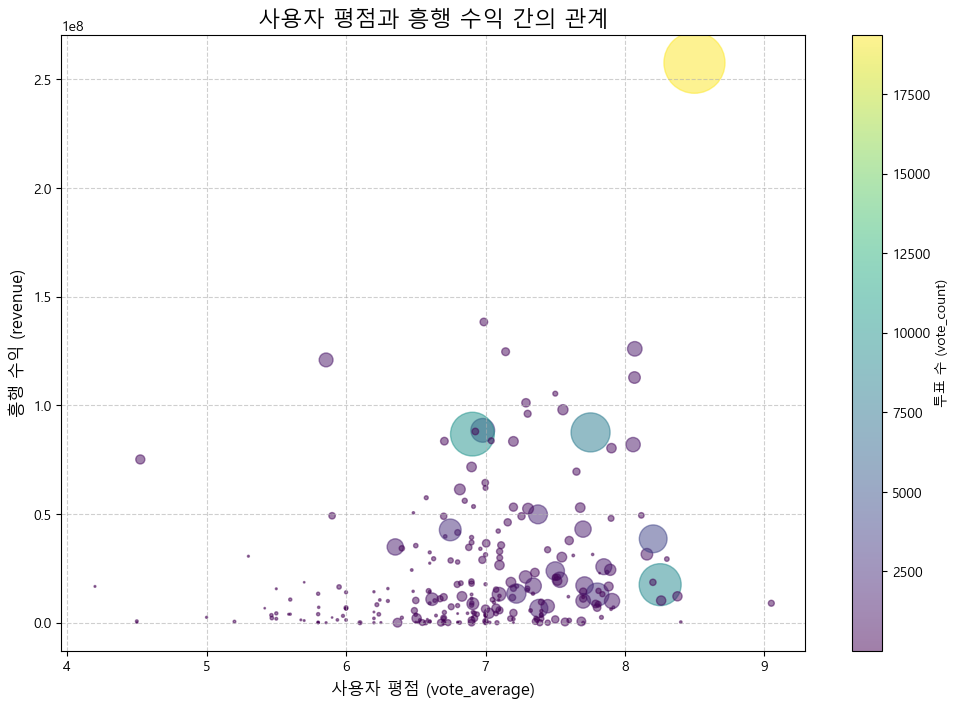


>>> ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ ÏàòÏùµÏù¥ ÎÇÆÏùÄ ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)


title  vote_average    revenue  vote_count
2948   Î∏åÎ†àÏù¥ÌÅ¨ Îçî ÏÇ¨ÏùºÎü∞Ïä§: Îçî Î¨¥ÎπÑ         9.049    8954945         184
1939                 Í∏∞ÏÉùÏ∂©         8.498  257591776       19364
4381   Í∑∏ ÏãúÏ†à, Ïö∞Î¶¨Í∞Ä Ï¢ãÏïÑÌñàÎçò ÏÜåÎÖÄ         8.400     302086          32
2447       Î∏åÎßÅ Îçî ÏÜåÏö∏: Îçî Î¨¥ÎπÑ         8.376   12150259         444
3896  Î∞©ÌÉÑÏÜåÎÖÑÎã®: Ïòõ Ìà¨ Ïª¥ Ïù∏ ÏãúÎÑ§Îßà         8.300   29291883         107


>>> Ìù•Ìñâ ÏàòÏùµÏùÄ ÎÜíÏßÄÎßå ÌèâÏ†êÏù¥ ÎÇÆÏùÄ ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)


title  vote_average    revenue  vote_count
1939         Í∏∞ÏÉùÏ∂©         8.498  257591776       19364
876           Î™ÖÎüâ         6.988  138342258         300
1326   Ïã†Í≥ºÌï®Íªò-Ï£ÑÏôÄ Î≤å         8.070  125983972        1099
2203        Í∑πÌïúÏßÅÏóÖ         7.144  124652206         316
718   ÎÑõÏû°: ÎïÖÏΩ© ÎèÑÎëëÎì§         5.857  120885527        1000

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# matplotlibÏóêÏÑú ÌïúÍ∏Ä Ìè∞Ìä∏Í∞Ä Íπ®ÏßÄÎäî Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï©ÎãàÎã§.
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print(">>> TMDB ÏòÅÌôî Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")

# 1. ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
file_path = 'tmdb_kr_theatrical_2005_2025.csv'
try:
    df = pd.read_csv(file_path)
    print(f"'{file_path}' ÌååÏùºÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§. Ï¥ù {len(df)}Í∞úÏùò ÏòÅÌôî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÏäµÎãàÎã§.")
except FileNotFoundError:
    print(f"Ïò§Î•ò: '{file_path}' ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. ÌååÏùº Í≤ΩÎ°úÎ•º ÌôïÏù∏Ìï¥ Ï£ºÏÑ∏Ïöî.")
    exit()

# 2. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú Î∞è ÌïÑÌÑ∞ÎßÅ
# Î∂ÑÏÑùÏùò Ï†ïÌôïÏÑ±ÏùÑ ÏúÑÌï¥ ÏàòÏùµÏù¥ 0Ïù¥Í±∞ÎÇò Ìà¨Ìëú ÏàòÍ∞Ä 10Í∞ú ÎØ∏ÎßåÏù∏ ÏòÅÌôîÎäî Ï†úÏô∏Ìï©ÎãàÎã§.
df_filtered = df[(df['revenue'] > 0) & (df['vote_count'] >= 10)].copy()
print(f"Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ ÏàòÏùµÏù¥ ÏûàÍ≥† Ìà¨Ìëú ÏàòÍ∞Ä 10Í∞ú Ïù¥ÏÉÅÏù∏ {len(df_filtered)}Í∞úÏùò ÏòÅÌôîÎ•º ÌïÑÌÑ∞ÎßÅÌñàÏäµÎãàÎã§.")

# 3. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≥ÑÏÇ∞
# ÏÇ¨Ïö©Ïûê ÌèâÏ†ê(vote_average)Í≥º Ìù•Ìñâ ÏàòÏùµ(revenue) Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàòÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
correlation = df_filtered['vote_average'].corr(df_filtered['revenue'])
print(f"\n>>> ÏÇ¨Ïö©Ïûê ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàò: {correlation:.4f}")

# 4. Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 8))
plt.scatter(df_filtered['vote_average'], df_filtered['revenue'], alpha=0.5, c=df_filtered['vote_count'], cmap='viridis', s=df_filtered['vote_count']/10)
plt.title('ÏÇ¨Ïö©Ïûê ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í∞ÑÏùò Í¥ÄÍ≥Ñ', fontsize=16)
plt.xlabel('ÏÇ¨Ïö©Ïûê ÌèâÏ†ê (vote_average)', fontsize=12)
plt.ylabel('Ìù•Ìñâ ÏàòÏùµ (revenue)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.colorbar(label='Ìà¨Ìëú Ïàò (vote_count)')
plt.show()

# 5. ÌäπÏù¥ ÏÇ¨Î°Ä Î∂ÑÏÑù
# Ìù•Ìñâ ÏàòÏùµÏù¥ ÎÇÆÏßÄÎßå ÌèâÏ†êÏù¥ ÎÜíÏùÄ ÏòÅÌôîÎ•º Ï∞æÏäµÎãàÎã§ (ÎπÑÍµêÏ†Å Ï†ÅÏùÄ Ìà¨Ìëú ÏàòÏùº Ïàò ÏûàÏúºÎØÄÎ°ú ÏÉÅÏúÑ 5Í∞úÎ•º Ï∂îÏ∂ú)
high_rating_low_revenue = df_filtered.sort_values(by=['vote_average', 'revenue'], ascending=[False, True]).head(5)
print("\n>>> ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ ÏàòÏùµÏù¥ ÎÇÆÏùÄ ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)")
display(high_rating_low_revenue[['title', 'vote_average', 'revenue', 'vote_count']])

# ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏàòÏùµÏù¥ ÎÜíÏùÄ ÏòÅÌôîÎ•º Ï∞æÏäµÎãàÎã§.
low_rating_high_revenue = df_filtered.sort_values(by=['revenue', 'vote_average'], ascending=[False, True]).head(5)
print("\n>>> Ìù•Ìñâ ÏàòÏùµÏùÄ ÎÜíÏßÄÎßå ÌèâÏ†êÏù¥ ÎÇÆÏùÄ ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)")
display(low_rating_high_revenue[['title', 'vote_average', 'revenue', 'vote_count']])


#### **ÌèâÏ†ê ÏàòÏ§ÄÏóê ÎπÑÌï¥ ÏàòÏùµÏù¥ ÎÇÆÏùÄ ÏòÅÌôî**
- ÌèâÏ†êÍ≥º ÏàòÏùµÏùÑ Î™®Îëê 0 ~ 1 ÏÇ¨Ïù¥Ïùò Ï†êÏàòÎ°ú Î∞îÍøîÏÑú Ï†ïÍ∑úÌôî Ìïú ÌõÑ Î∂ÑÏÑù
- Ï†ïÍ∑úÌôî : Îç∞Ïù¥ÌÑ∞Ïùò Î≤îÏúÑÎ•º 0Í≥º 1 ÏÇ¨Ïù¥Î°ú Î≥ÄÌôòÌïòÎäî ÏûëÏóÖ 
    - Ï†ïÍ∑úÌôîÎêú Í∞í = (ÏõêÎ≥∏ Í∞í - ÏµúÏÜåÍ∞í) / (ÏµúÎåÄÍ∞í - ÏµúÏÜåÍ∞í)

>>> ÏòÅÌôî ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í¥ÄÍ≥ÑÏóê ÎåÄÌïú ÏãúÍ∞ÅÌôîÎ•º ÏãúÏûëÌï©ÎãàÎã§.
'tmdb_kr_theatrical_2005_2025.csv' ÌååÏùºÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.
Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ ÏàòÏùµÏù¥ ÏûàÍ≥† Ìà¨Ìëú ÏàòÍ∞Ä 10Í∞ú Ïù¥ÏÉÅÏù¥Î©∞ ÌèâÏ†êÏù¥ 0Î≥¥Îã§ ÌÅ∞ 258Í∞úÏùò ÏòÅÌôîÎ•º ÌïÑÌÑ∞ÎßÅÌñàÏäµÎãàÎã§.


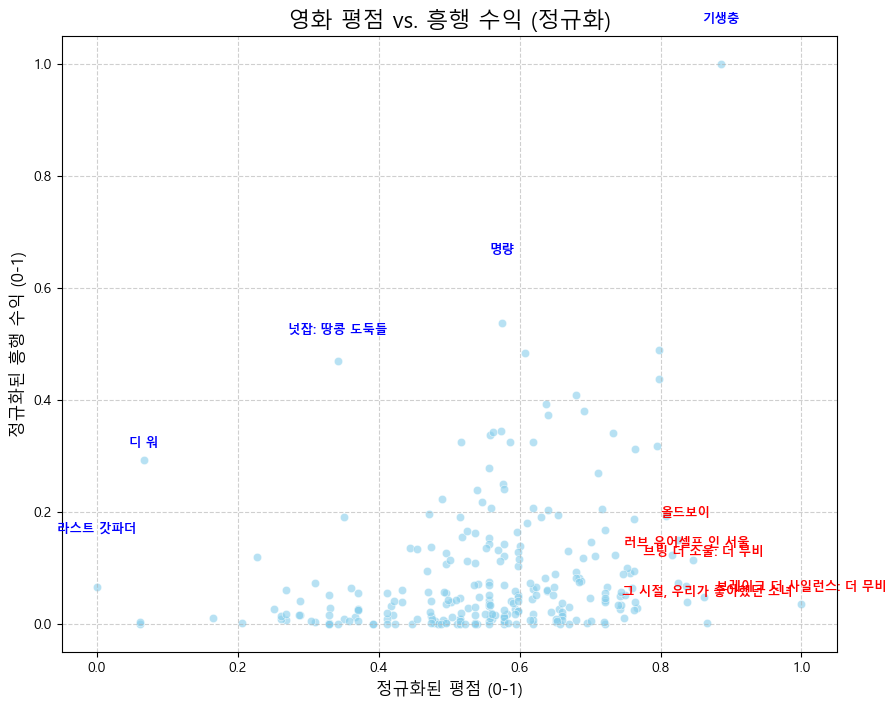

<Figure size 1200x600 with 0 Axes>

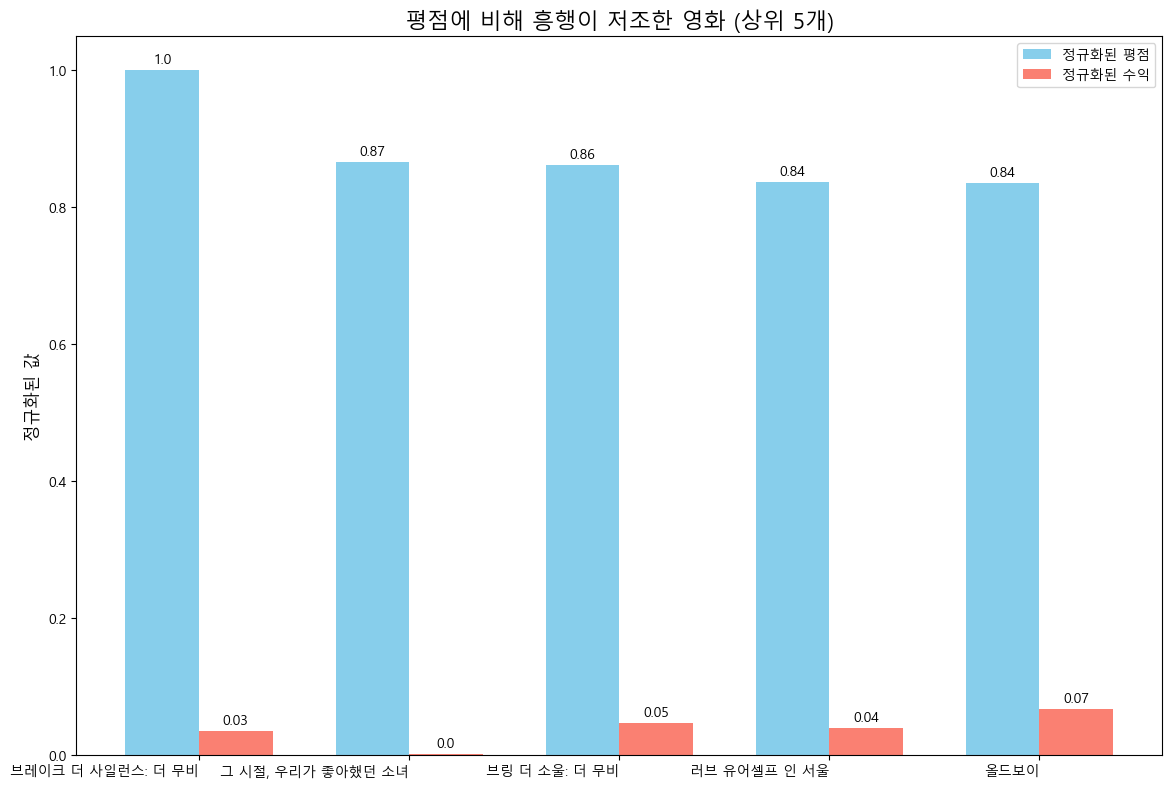

<Figure size 1200x600 with 0 Axes>

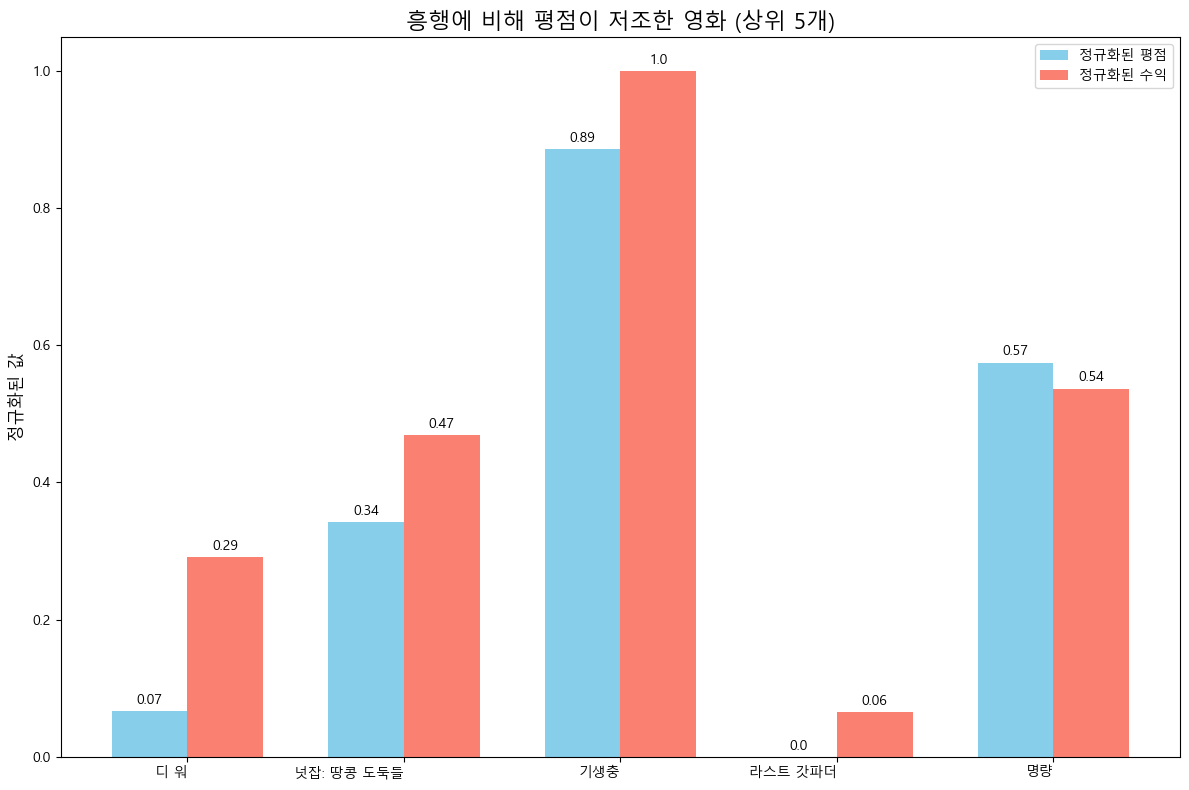

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

# matplotlibÏóêÏÑú ÌïúÍ∏Ä Ìè∞Ìä∏Í∞Ä Íπ®ÏßÄÎäî Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï©ÎãàÎã§.
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print(">>> ÏòÅÌôî ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í¥ÄÍ≥ÑÏóê ÎåÄÌïú ÏãúÍ∞ÅÌôîÎ•º ÏãúÏûëÌï©ÎãàÎã§.")

# 1. ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
file_path = 'tmdb_kr_theatrical_2005_2025.csv'
try:
    df = pd.read_csv(file_path)
    print(f"'{file_path}' ÌååÏùºÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
except FileNotFoundError:
    print(f"Ïò§Î•ò: '{file_path}' ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. ÌååÏùº Í≤ΩÎ°úÎ•º ÌôïÏù∏Ìï¥ Ï£ºÏÑ∏Ïöî.")
    exit()

# 2. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú Î∞è ÌïÑÌÑ∞ÎßÅ
# ÏàòÏùµÏù¥ ÏûàÍ≥†, Ìà¨Ìëú ÏàòÍ∞Ä 10Í∞ú Ïù¥ÏÉÅÏù¥Î©∞, ÌèâÏ†êÏù¥ 0Î≥¥Îã§ ÌÅ∞ ÏòÅÌôîÎßå ÌïÑÌÑ∞ÎßÅÌï©ÎãàÎã§.
df_filtered = df[(df['revenue'] > 0) & (df['vote_count'] >= 10) & (df['vote_average'] > 0)].copy()
print(f"Î∂ÑÏÑùÏùÑ ÏúÑÌï¥ ÏàòÏùµÏù¥ ÏûàÍ≥† Ìà¨Ìëú ÏàòÍ∞Ä 10Í∞ú Ïù¥ÏÉÅÏù¥Î©∞ ÌèâÏ†êÏù¥ 0Î≥¥Îã§ ÌÅ∞ {len(df_filtered)}Í∞úÏùò ÏòÅÌôîÎ•º ÌïÑÌÑ∞ÎßÅÌñàÏäµÎãàÎã§.")

# 3. Îç∞Ïù¥ÌÑ∞ Ï†ïÍ∑úÌôî (MinMaxScaler ÏßÅÏ†ë Íµ¨ÌòÑ)
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df_filtered['normalized_vote_average'] = min_max_normalize(df_filtered['vote_average'])
df_filtered['normalized_revenue'] = min_max_normalize(df_filtered['revenue'])

# 4. ÌäπÏù¥ ÏÇ¨Î°Ä Î∂ÑÏÑùÏùÑ ÏúÑÌïú ÏÉàÎ°úÏö¥ ÏßÄÌëú Í≥ÑÏÇ∞
df_filtered['rating_minus_revenue'] = df_filtered['normalized_vote_average'] - df_filtered['normalized_revenue']
df_filtered['revenue_minus_rating'] = df_filtered['normalized_revenue'] - df_filtered['normalized_vote_average']

# 5. ÏãúÍ∞ÅÌôî ÏãúÏûë

# 5-1. ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµÏùò Í¥ÄÍ≥ÑÎ•º ÎÇòÌÉÄÎÇ¥Îäî ÏÇ∞Ï†êÎèÑ
plt.figure(figsize=(10, 8))
plt.scatter(df_filtered['normalized_vote_average'], df_filtered['normalized_revenue'], alpha=0.6, color='skyblue', edgecolors='w', linewidths=0.5)
plt.title('ÏòÅÌôî ÌèâÏ†ê vs. Ìù•Ìñâ ÏàòÏùµ (Ï†ïÍ∑úÌôî)', fontsize=16)
plt.xlabel('Ï†ïÍ∑úÌôîÎêú ÌèâÏ†ê (0-1)', fontsize=12)
plt.ylabel('Ï†ïÍ∑úÌôîÎêú Ìù•Ìñâ ÏàòÏùµ (0-1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# ÌèâÏ†êÏóê ÎπÑÌï¥ ÏàòÏùµÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)
high_rating_low_revenue_movies = df_filtered.sort_values(by='rating_minus_revenue', ascending=False).head(5)
# ÌÖçÏä§Ìä∏ ÏúÑÏπò Í≤πÏπ® Î∞©ÏßÄÎ•º ÏúÑÌï¥ offsetÏùÑ Ï∂îÍ∞ÄÌï©ÎãàÎã§.
offset = 10
for i, row in high_rating_low_revenue_movies.iterrows():
    plt.annotate(row['title'], (row['normalized_vote_average'], row['normalized_revenue']), 
                 textcoords="offset points", xytext=(0, offset), ha='center',
                 color='red', fontweight='bold', fontsize=9)
    offset += 10 # ÌÖçÏä§Ìä∏Í∞Ä Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù yÏ∂ï offsetÏùÑ Ï¶ùÍ∞ÄÏãúÌÇµÎãàÎã§.

# ÏàòÏùµÏóê ÎπÑÌï¥ ÌèâÏ†êÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)
low_rating_high_revenue_movies = df_filtered.sort_values(by='revenue_minus_rating', ascending=False).head(5)
# ÌÖçÏä§Ìä∏ ÏúÑÏπò Í≤πÏπ® Î∞©ÏßÄÎ•º ÏúÑÌï¥ offsetÏùÑ Ï∂îÍ∞ÄÌï©ÎãàÎã§.
offset = 10
for i, row in low_rating_high_revenue_movies.iterrows():
    plt.annotate(row['title'], (row['normalized_vote_average'], row['normalized_revenue']), 
                 textcoords="offset points", xytext=(0, offset), ha='center',
                 color='blue', fontweight='bold', fontsize=9)
    offset += 10 # ÌÖçÏä§Ìä∏Í∞Ä Í≤πÏπòÏßÄ ÏïäÎèÑÎ°ù yÏ∂ï offsetÏùÑ Ï¶ùÍ∞ÄÏãúÌÇµÎãàÎã§.

plt.show()

# 5-2. ÌèâÏ†êÏóê ÎπÑÌï¥ Ìù•ÌñâÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))
# ÎßâÎåÄ Í∑∏ÎûòÌîÑÎ•º Í∑∏Î¶ΩÎãàÎã§. xÏ∂ïÏùÄ ÏòÅÌôî Ï†úÎ™©, yÏ∂ïÏùÄ 'normalized_vote_average'ÏôÄ 'normalized_revenue'
x = np.arange(len(high_rating_low_revenue_movies))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, high_rating_low_revenue_movies['normalized_vote_average'], width, label='Ï†ïÍ∑úÌôîÎêú ÌèâÏ†ê', color='skyblue')
rects2 = ax.bar(x + width/2, high_rating_low_revenue_movies['normalized_revenue'], width, label='Ï†ïÍ∑úÌôîÎêú ÏàòÏùµ', color='salmon')

# ÎßâÎåÄ ÏúÑÏóê Í∞í Ï∂îÍ∞Ä
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax)
autolabel(rects2, ax)

ax.set_title('ÌèâÏ†êÏóê ÎπÑÌï¥ Ìù•ÌñâÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)', fontsize=16)
ax.set_ylabel('Ï†ïÍ∑úÌôîÎêú Í∞í', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(high_rating_low_revenue_movies['title'], rotation=0, ha='right', fontsize=10)
ax.legend()
plt.tight_layout()
plt.show()

# 5-3. Ìù•ÌñâÏóê ÎπÑÌï¥ ÌèâÏ†êÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12, 6))

x = np.arange(len(low_rating_high_revenue_movies))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, low_rating_high_revenue_movies['normalized_vote_average'], width, label='Ï†ïÍ∑úÌôîÎêú ÌèâÏ†ê', color='skyblue')
rects2 = ax.bar(x + width/2, low_rating_high_revenue_movies['normalized_revenue'], width, label='Ï†ïÍ∑úÌôîÎêú ÏàòÏùµ', color='salmon')

# ÎßâÎåÄ ÏúÑÏóê Í∞í Ï∂îÍ∞Ä
autolabel(rects1, ax)
autolabel(rects2, ax)

ax.set_title('Ìù•ÌñâÏóê ÎπÑÌï¥ ÌèâÏ†êÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)', fontsize=16)
ax.set_ylabel('Ï†ïÍ∑úÌôîÎêú Í∞í', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(low_rating_high_revenue_movies['title'], rotation=0, ha='right', fontsize=10)
ax.legend()
plt.tight_layout()
plt.show()


### ÏòÅÌôî ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù Î≥¥Í≥†ÏÑú
#### ÏÑúÎ°†

Î≥∏ Î≥¥Í≥†ÏÑúÎäî 2005ÎÖÑÎ∂ÄÌÑ∞ 2025ÎÖÑÍπåÏßÄÏùò ÌïúÍµ≠ ÏòÅÌôî Îç∞Ïù¥ÌÑ∞Î•º Î∞îÌÉïÏúºÎ°ú ÏÇ¨Ïö©Ïûê ÌèâÏ†ê(vote_average)Í≥º Î∞ïÏä§Ïò§ÌîºÏä§ ÏàòÏùµ(revenue) Í∞ÑÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÎ•º Î∂ÑÏÑùÌïòÍ≥†, ÌèâÏ†êÍ≥º Ìù•Ìñâ Í∞ÑÏùò Î∂àÏùºÏπòÍ∞Ä ÎÇòÌÉÄÎÇòÎäî ÏòÅÌôîÎì§Ïùò ÌäπÏÑ±ÏùÑ Ïã¨Ï∏µÏ†ÅÏúºÎ°ú ÌÉêÍµ¨ÌïúÎã§. ÌäπÌûà, ÎÜíÏùÄ ÌèâÏ†êÏùÑ Î∞õÏïòÏßÄÎßå Ìù•ÌñâÏóê Ïã§Ìå®Ìïú ÏòÅÌôîÏôÄ ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•ÌñâÏóê ÏÑ±Í≥µÌïú ÏòÅÌôîÏùò Í≥µÌÜµÏ†ê Î∞è Ï∞®Ïù¥Ï†êÏùÑ ÎπÑÍµêÌï®ÏúºÎ°úÏç® ÏòÅÌôî ÏÇ∞ÏóÖÏùò Ìù•Ìñâ ÏöîÏù∏Ïóê ÎåÄÌïú Ïù¥Ìï¥Î•º ÎÑìÌûàÍ≥†Ïûê ÌïúÎã§.

1. ÏòÅÌôî ÌèâÏ†ê vs. Ìù•Ìñâ ÏàòÏùµ ÏÇ∞Ï†êÎèÑ Î∂ÑÏÑù
Ï≤´ Î≤àÏß∏ Í∑∏ÎûòÌîÑÎäî Ï†ïÍ∑úÌôîÎêú ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú Î≥¥Ïó¨Ï§çÎãàÎã§. Í∞Å Ï†êÏùÄ ÌïòÎÇòÏùò ÏòÅÌôîÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§.

„ÄäÍ∏∞ÏÉùÏ∂©„Äã: ÌèâÏ†ê(ÏïΩ 0.9)Í≥º Ìù•Ìñâ ÏàòÏùµ(ÏïΩ 1.0) Î™®Îëê ÏïïÎèÑÏ†ÅÏúºÎ°ú ÎÜíÏïÑ, ÏûëÌíàÏÑ±Í≥º ÎåÄÏ§ëÏÑ± Î™®ÎëêÎ•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú ÌôïÎ≥¥Ìïú ÏÇ¨Î°ÄÎ°ú ÎÇòÌÉÄÎÇ©ÎãàÎã§.

ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ Ìù•Ìñâ: Ïò§Î•∏Ï™Ω ÌïòÎã®Ïóê ÏúÑÏπòÌïú ÏòÅÌôîÎì§(Ïòà: „ÄäÏò¨ÎìúÎ≥¥Ïù¥„Äã)ÏùÄ ÌèâÏ†êÏù¥ ÎÜíÏßÄÎßå Ìù•Ìñâ ÏàòÏùµÏùÄ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏïÑ, ÎπÑÌèâÍ∞ÄÎÇò ÌäπÏ†ï Ìå¨Ï∏µÏùò Ìò∏ÌèâÏùÑ Î∞õÏïòÏúºÎÇò ÎåÄÏ§ëÏ†Å Ïù∏Í∏∞Î°úÎäî Ïù¥Ïñ¥ÏßÄÏßÄ ÏïäÏïòÏùåÏùÑ ÏãúÏÇ¨Ìï©ÎãàÎã§.

Îç∞Ïù¥ÌÑ∞Ïùò ÌäπÏßï: Ìà¨ÌëúÏàòÎ•º 10Í∞ú Ïù¥ÏÉÅÏúºÎ°ú Ï†úÌïúÌñàÏùÑ Îïå, ÌèâÏ†êÏù¥ Îß§Ïö∞ ÎÇÆÏúºÎ©¥ÏÑú Ìù•ÌñâÏóê ÌÅ¨Í≤å ÏÑ±Í≥µÌïú ÏòÅÌôîÎäî Í±∞Ïùò ÎÇòÌÉÄÎÇòÏßÄ ÏïäÏïòÏäµÎãàÎã§. Ïù¥Îäî Ïã†Î¢∞Ìï† ÎßåÌïú ÎåÄÏ§ëÏùò ÌèâÍ∞ÄÏóêÏÑúÎäî ÌèâÏ†êÍ≥º Ìù•ÌñâÏù¥ Ïñ¥Îäê Ï†ïÎèÑ ÎπÑÎ°ÄÌï®ÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§.

2. ÌèâÏ†êÏóê ÎπÑÌï¥ Ìù•ÌñâÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)
Îëê Î≤àÏß∏ ÎßâÎåÄ Í∑∏ÎûòÌîÑÎäî ÌèâÏ†êÏóê ÎπÑÌï¥ Ìù•Ìñâ ÏàòÏùµÏù¥ ÎÇÆÏùÄ ÏòÅÌôîÎì§ÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§. Ïù¥Îäî 'ÏûëÌíàÏÑ±ÏùÄ ÎÜíÏúºÎÇò Ìù•ÌñâÏóê Ïã§Ìå®Ìïú' ÏòÅÌôîÎì§Î°ú Ìï¥ÏÑùÌï† Ïàò ÏûàÏäµÎãàÎã§.

Ï£ºÏöî ÌäπÏßï: ÌèâÏ†ê(ÌååÎûÄÏÉâ ÎßâÎåÄ)ÏùÄ ÎÜíÍ≤å ÎÇòÌÉÄÎÇòÏßÄÎßå, Ìù•Ìñâ ÏàòÏùµ(Ï£ºÌô©ÏÉâ ÎßâÎåÄ)ÏùÄ ÌòÑÏ†ÄÌûà ÎÇÆÏäµÎãàÎã§. ÌäπÌûà **„ÄäÎ∏åÎ†àÏù¥ÌÅ¨ Îçî ÏÇ¨ÏùºÎü∞Ïä§ Îçî Î¨¥ÎπÑ„Äã**Îäî ÌèâÏ†êÏù¥ ÏµúÍ≥†Ïπò(1.0)ÏûÑÏóêÎèÑ Ìù•Ìñâ ÏàòÏùµÏù¥ Îß§Ïö∞ ÎÇÆÏïÑ, ÌäπÏ†ï Ìå¨Îç§Ïùò ÎÜíÏùÄ ÌèâÍ∞ÄÍ∞Ä Î∞òÏòÅÎêú Í≤∞Í≥ºÎ°ú Ï∂îÏ†ïÎê©ÎãàÎã§.

ÏãúÏÇ¨Ï†ê: ÏûëÌíàÏùò ÏôÑÏÑ±ÎèÑÎÇò ÌèâÎ°†Í∞Ä ÌèâÏ†êÎßåÏúºÎ°úÎäî Ìù•Ìñâ ÏÑ±Í≥µÏùÑ Î≥¥Ïû•Ìï† Ïàò ÏóÜÎã§Îäî Ï†êÏùÑ Í∞ïÏ°∞Ìï©ÎãàÎã§.

3. Ìù•ÌñâÏóê ÎπÑÌï¥ ÌèâÏ†êÏù¥ Ï†ÄÏ°∞Ìïú ÏòÅÌôî (ÏÉÅÏúÑ 5Í∞ú)
ÏÑ∏ Î≤àÏß∏ ÎßâÎåÄ Í∑∏ÎûòÌîÑÎäî Ìù•Ìñâ ÏàòÏùµÏùÄ ÎÜíÏßÄÎßå ÌèâÏ†êÏùÄ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏùÄ ÏòÅÌôîÎì§ÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§. Ïù¥Îäî 'Ìù•ÌñâÏóêÎäî ÏÑ±Í≥µÌñàÏúºÎÇò ÌèâÍ∞ÄÍ∞Ä ÏóáÍ∞àÎ¶¨Îäî' ÏòÅÌôîÎì§ÏûÖÎãàÎã§.

Ï£ºÏöî ÌäπÏßï: Ìù•Ìñâ ÏàòÏùµ(Ï£ºÌô©ÏÉâ ÎßâÎåÄ)Ïù¥ ÌèâÏ†ê(ÌååÎûÄÏÉâ ÎßâÎåÄ)Î≥¥Îã§ ÎÜíÏùÄ Í≤ΩÏö∞Í∞Ä ÎßéÏäµÎãàÎã§. **„ÄäÎîî Ïõå„Äã**ÎÇò **„ÄäÎùºÏä§Ìä∏ Í∞ìÌååÎçî„Äã**Ï≤òÎüº ÎåÄÍ∑úÎ™® ÎßàÏºÄÌåÖÏù¥ÎÇò ÎåÄÏ§ëÏùò Ìò∏Í∏∞Ïã¨ÏùÑ ÏûêÍ∑πÌïòÏó¨ Ìù•ÌñâÏóê ÏÑ±Í≥µÌñàÏßÄÎßå, ÏûëÌíàÏÑ±Ïóê ÎåÄÌïú ÌèâÍ∞ÄÎäî ÎÜíÏßÄ ÏïäÏïòÎçò ÏòÅÌôîÎì§Ïù¥ Ïó¨Í∏∞Ïóê ÏÜçÌï©ÎãàÎã§.

**„ÄäÍ∏∞ÏÉùÏ∂©„ÄãÏùò ÏúÑÏπò: Ïù¥ Í∑∏Î£πÏóê Ìè¨Ìï®Îêú **„ÄäÍ∏∞ÏÉùÏ∂©„Äã**ÏùÄ ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Î™®Îëê ÎÜíÏßÄÎßå, ÏÉÅÎåÄÏ†ÅÏúºÎ°ú Ìù•Ìñâ ÏàòÏùµÏù¥ ÌèâÏ†êÎ≥¥Îã§ Îçî ÏïïÎèÑÏ†ÅÏù∏ ÏàòÏπòÎ•º Í∏∞Î°ùÌñàÏùåÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§.

Í≤∞Î°†
Ìà¨ÌëúÏàò 10Í∞ú Ïù¥ÏÉÅÏúºÎ°ú ÌïÑÌÑ∞ÎßÅÎêú Îç∞Ïù¥ÌÑ∞ Î∂ÑÏÑù Í≤∞Í≥º, ÏòÅÌôîÏùò ÏûëÌíàÏÑ±Í≥º ÎåÄÏ§ëÏ†Å Ìù•ÌñâÏùÄ Î∞òÎìúÏãú ÏùºÏπòÌïòÏßÄ ÏïäÎäîÎã§Îäî Í≤ÉÏùÑ Ïïå Ïàò ÏûàÏäµÎãàÎã§. ÌèâÏ†êÏù¥ ÎÜíÎçîÎùºÎèÑ Ìù•ÌñâÏóê Ïã§Ìå®Ìï† Ïàò ÏûàÏúºÎ©∞, Î∞òÎåÄÎ°ú Ìù•ÌñâÏóê ÏÑ±Í≥µÌïòÎçîÎùºÎèÑ ÌèâÏ†êÏù¥ ÎÇÆÏùÑ Ïàò ÏûàÏäµÎãàÎã§. ÌïòÏßÄÎßå Í∑πÌûà ÎìúÎ¨ºÍ≤å **„ÄäÍ∏∞ÏÉùÏ∂©„Äã**Í≥º Í∞ôÏù¥ Îëê ÎßàÎ¶¨ ÌÜ†ÎÅºÎ•º Î™®Îëê Ïû°Îäî ÏòÅÌôîÎèÑ Ï°¥Ïû¨Ìï®ÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

#### **1. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù Î∞è ÏÇ∞Ï†êÎèÑ ÏãúÍ∞ÅÌôî:**

ÌèâÏ†ê(vote_average)Í≥º Ìù•Ìñâ ÏàòÏùµ(revenue) Îëê Î≥ÄÏàò Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º ÏÇ∞Ï†êÎèÑ(scatter plot)Î°ú Í∑∏Î†§Î≥¥ÏÑ∏Ïöî. xÏ∂ïÏùÑ ÌèâÏ†ê, yÏ∂ïÏùÑ ÏàòÏùµÏúºÎ°ú ÎëêÎ©¥ ÌèâÏ†êÏù¥ ÎÜíÏùÑÏàòÎ°ù ÏàòÏùµÏù¥ ÎÜíÏïÑÏßÄÎäî Í≤ΩÌñ•ÏùÑ ÏãúÍ∞ÅÏ†ÅÏúºÎ°ú ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≥ÑÏàòÎ•º Í≥ÑÏÇ∞ÌïòÏó¨ Îëê Î≥ÄÏàò Í∞ÑÏùò ÏÑ†ÌòïÏ†Å Í¥ÄÍ≥Ñ Í∞ïÎèÑÎ•º Ï†ïÎüâÏ†ÅÏúºÎ°ú ÎÇòÌÉÄÎÇ¥ÏÑ∏Ïöî.

Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.


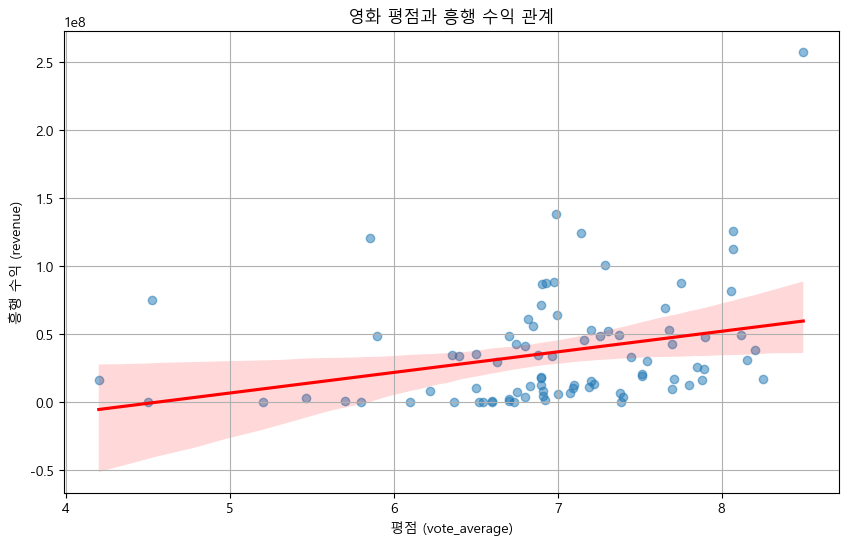


ÌèâÏ†êÍ≥º ÏàòÏùµ Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàò: 0.2928


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

# Í≤ΩÍ≥† Î©îÏãúÏßÄ Î¨¥Ïãú
warnings.filterwarnings('ignore', category=UserWarning)

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows ÏÇ¨Ïö©ÏûêÏö©)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
file_path = 'tmdb_kr_theatrical_clean.csv'
try:
    df = pd.read_csv(file_path)
    print("Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
    
    # 2. ÌïÑÏöîÌïú Ïó¥ ÏÑ†ÌÉù (ÌèâÏ†êÍ≥º ÏàòÏùµ)
    df = df[['vote_average', 'revenue']]
    
    # 3. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú: 0Ïù¥Í±∞ÎÇò Ìà¨Ìëú ÏàòÍ∞Ä Ï†ÅÏùÄ Îç∞Ïù¥ÌÑ∞Îäî Ï†úÏô∏
    # (Ïù¥ÎØ∏ Ï†Ñ Îã®Í≥ÑÏóêÏÑú Ï†ïÏ†úÌñàÎã§Í≥† Í∞ÄÏ†ï)
    
    # 4. ÏÇ∞Ï†êÎèÑ(Scatter Plot) Í∑∏Î¶¨Í∏∞
    plt.figure(figsize=(10, 6))
    sns.regplot(x='vote_average', y='revenue', data=df, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title('ÏòÅÌôî ÌèâÏ†êÍ≥º Ìù•Ìñâ ÏàòÏùµ Í¥ÄÍ≥Ñ')
    plt.xlabel('ÌèâÏ†ê (vote_average)')
    plt.ylabel('Ìù•Ìñâ ÏàòÏùµ (revenue)')
    plt.grid(True)
    plt.show()

    # 5. ÏÉÅÍ¥ÄÍ≥ÑÏàò(Correlation Coefficient) Í≥ÑÏÇ∞
    correlation = df['vote_average'].corr(df['revenue'])
    print(f"\nÌèâÏ†êÍ≥º ÏàòÏùµ Í∞ÑÏùò ÏÉÅÍ¥ÄÍ≥ÑÏàò: {correlation:.4f}")

except FileNotFoundError:
    print(f"Ïò§Î•ò: {file_path} ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§. ÌååÏùº Í≤ΩÎ°úÎ•º Îã§Ïãú ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")
except KeyError:
    print("Ïò§Î•ò: Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê 'vote_average' ÎòêÎäî 'revenue' Ïó¥Ïù¥ ÏóÜÏäµÎãàÎã§. Ïó¥ Ïù¥Î¶ÑÏùÑ ÌôïÏù∏Ìï¥Ï£ºÏÑ∏Ïöî.")

#### **2. ÌäπÏù¥Ï†ê(Outlier) Ï∞æÍ∏∞:**

ÏÇ∞Ï†êÎèÑÏóêÏÑú ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå ÏàòÏùµÏùÄ ÎÇÆÏùÄ ÏòÅÌôî, ÎòêÎäî ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå ÏàòÏùµÏùÄ ÎÜíÏùÄ ÏòÅÌôî Îì± ÏùºÎ∞òÏ†ÅÏù∏ Í≤ΩÌñ•ÏóêÏÑú Î≤óÏñ¥ÎÇòÎäî Ï†êÎì§ÏùÑ Ï∞æÏïÑÎ≥¥ÏÑ∏Ïöî.
Ïù¥ ÏòÅÌôîÎì§Ïùò Ïù¥Î¶ÑÏùÑ Î≥ÑÎèÑÎ°ú Î¶¨Ïä§Ìä∏ÏóÖÌïòÍ≥†, Í∑∏ ÏòÅÌôîÎì§Ïùò ÌäπÏßïÏùÑ ÏÇ¥Ìé¥Î¥ÖÎãàÎã§.

-  MinMaxScalerÎ•º ÏÇ¨Ïö©Ìï¥ Ï†ïÍ∑úÌôî ÏãúÌÇ§Í∏∞

    - üìà MinMaxScaler (ÏµúÏÜå-ÏµúÎåÄ Ï†ïÍ∑úÌôî):
    MinMaxScalerÎäî Í∞Å Îç∞Ïù¥ÌÑ∞ Ìè¨Ïù∏Ìä∏Î•º 0Í≥º 1 ÏÇ¨Ïù¥Ïùò Í∞íÏúºÎ°ú Î≥ÄÌôòÌïòÎäî ÏùºÎ∞òÏ†ÅÏù∏ Ï†ïÍ∑úÌôî Í∏∞Î≤ïÏûÖÎãàÎã§. Ïù¥ Î∞©Î≤ïÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ Îç∞Ïù¥ÌÑ∞Ïùò ÏõêÎûò Î∂ÑÌè¨Îäî Ïú†ÏßÄÌïòÎ©¥ÏÑúÎèÑ, ÏÑúÎ°ú Îã§Î•∏ Î≤îÏúÑÎ•º Í∞ÄÏßÑ Î≥ÄÏàòÎì§(Ïòà: ÌèâÏ†ê 0~10 vs. ÏàòÏùµ Ïñµ Îã®ÏúÑ)ÏùÑ ÎèôÏùºÌïú Ï≤ôÎèÑÎ°ú ÎπÑÍµêÌï† Ïàò ÏûàÍ≤å Îê©ÎãàÎã§.

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
file_path = 'tmdb_kr_theatrical_clean.csv'
df = pd.read_csv(file_path)

# 2. ÌïÑÏöîÌïú Ïó¥Îßå Ï∂îÏ∂ú (Î∂ÑÏÑùÏóê ÌïÑÏöîÌïú Î™®Îì† Ïó¥ Ìè¨Ìï®)
df = df[['title', 'vote_average', 'revenue', 'budget', 'genres', 'original_language', 'popularity']]

# 3. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú: revenue ÎòêÎäî vote_averageÍ∞Ä 0Ïù∏ ÌñâÏùÄ Ï†úÏô∏
df = df[(df['revenue'] > 0) & (df['vote_average'] > 0)].copy()

# 4. ÌèâÏ†êÍ≥º ÏàòÏùµ Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
df[['normalized_vote', 'normalized_revenue']] = scaler.fit_transform(df[['vote_average', 'revenue']])

# 5. ÌäπÏù¥Ï†ê Í∑∏Î£π Ï†ïÏùò
# 'ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ' Í∑∏Î£π (ÌèâÏ†ê ÏÉÅÏúÑ 30%, ÏàòÏùµ ÌïòÏúÑ 30%)
high_vote_low_revenue_group = df[
    (df['normalized_vote'] >= df['normalized_vote'].quantile(0.7)) &
    (df['normalized_revenue'] <= df['normalized_revenue'].quantile(0.3))
]

# 'ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ' Í∑∏Î£π (ÌèâÏ†ê ÌïòÏúÑ 30%, ÏàòÏùµ ÏÉÅÏúÑ 30%)
low_vote_high_revenue_group = df[
    (df['normalized_vote'] <= df['normalized_vote'].quantile(0.3)) &
    (df['normalized_revenue'] >= df['normalized_revenue'].quantile(0.7))
]

# 6. Í≤∞Í≥º Ï∂úÎ†• (display ÏÇ¨Ïö©)
print("--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ Ïã§Ìå®) ---")
display(high_vote_low_revenue_group[['title', 'vote_average', 'revenue', 'genres', 'budget']].sort_values(by='vote_average', ascending=False).head(10))

print("\n--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏÑ±Í≥µ) ---")
display(low_vote_high_revenue_group[['title', 'vote_average', 'revenue', 'genres', 'budget']].sort_values(by='revenue', ascending=False).head(10))

--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ Ïã§Ìå®) ---


title  vote_average   revenue  \
56        Î†àÎìúÏäàÏ¶à         7.700  10054356   
13  ÏäàÌçºÎß®Ïù¥ÏóàÎçò ÏÇ¨ÎÇòÏù¥         7.400   3848034   
59          Í≥µÏûë         7.389      3175   
57          Î≤ÑÎãù         7.382   6591038   

                                        genres    budget  
56  ['Ïï†ÎãàÎ©îÏù¥ÏÖò', 'ÌåêÌÉÄÏßÄ', 'Í∞ÄÏ°±', 'ÏΩîÎØ∏Îîî', 'Î°úÎß®Ïä§', 'Î™®Ìóò']  20000000  
13                       ['ÏΩîÎØ∏Îîî', 'ÎìúÎùºÎßà', 'Î°úÎß®Ïä§']   4250000  
59                        ['ÎìúÎùºÎßà', 'Ïó≠ÏÇ¨', 'Ïä§Î¶¥Îü¨']  17000000  
57                      ['ÎØ∏Ïä§ÌÑ∞Î¶¨', 'ÎìúÎùºÎßà', 'Ïä§Î¶¥Îü¨']   7280000


--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏÑ±Í≥µ) ---


title  vote_average    revenue  \
36  ÎÑõÏû°: ÎïÖÏΩ© ÎèÑÎëëÎì§         5.857  120885527   
4          Îîî Ïõå         4.525   75108998   
48      Ïù∏Ï≤úÏÉÅÎ•ôÏûëÏ†Ñ         5.900   49196532   
34         Î≤†Î•ºÎ¶∞         6.700   48965210   

                                     genres    budget  
36             ['Ïï†ÎãàÎ©îÏù¥ÏÖò', 'ÏΩîÎØ∏Îîî', 'Í∞ÄÏ°±', 'Î™®Ìóò']  42000000  
4   ['ÌåêÌÉÄÏßÄ', 'ÎìúÎùºÎßà', 'Í≥µÌè¨', 'Ïï°ÏÖò', 'Ïä§Î¶¥Îü¨', 'SF']  32000000  
48                ['Ïó≠ÏÇ¨', 'ÎìúÎùºÎßà', 'Ï†ÑÏüÅ', 'Ïï°ÏÖò']  12700000  
34                      ['Ïï°ÏÖò', 'Ïä§Î¶¥Îü¨', 'Î≤îÏ£Ñ']   9000000

#### **3. Í∑∏Î£πÎ≥Ñ ÌäπÏÑ± Î∂ÑÏÑù:**

ÏïûÏÑú Ï†úÏïàÌñàÎçò Í≤ÉÏ≤òÎüº Îç∞Ïù¥ÌÑ∞Î•º Ï†ïÍ∑úÌôîÌïòÍ≥†, ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÍ≥º ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùÑ Î™ÖÌôïÌûà Ï†ïÏùòÌïòÏÑ∏Ïöî.
Í∞Å Í∑∏Î£πÏóê ÏÜçÌïú ÏòÅÌôîÎì§Ïùò Í≥µÌÜµÏ†ÅÏù∏ ÌäπÏÑ±ÏùÑ Î∂ÑÏÑùÌï©ÎãàÎã§.

Ïû•Î•¥: Ïñ¥Îñ§ Ïû•Î•¥Ïùò ÏòÅÌôîÍ∞Ä Ïù¥ Í∑∏Î£πÏóê ÎßéÏù¥ ÏÜçÌï¥ ÏûàÎÇòÏöî?
Ï†úÏûë ÏòàÏÇ∞: Ï†ÄÏòàÏÇ∞ ÏòÅÌôîÏù∏Í∞ÄÏöî, ÏïÑÎãàÎ©¥ Í≥†ÏòàÏÇ∞ ÏòÅÌôîÏù∏Í∞ÄÏöî?
Î∞∞Ïö∞ Î∞è Í∞êÎèÖ: Ï∂úÏó∞ÏßÑÏù¥ÎÇò Í∞êÎèÖÏùò Ïù∏ÏßÄÎèÑÍ∞Ä ÎÜíÏïòÎÇòÏöî?
Í∞úÎ¥â ÏãúÍ∏∞: Ï£ºÎ°ú Ïñ¥Îäê ÏãúÍ∏∞(ÏÑ±ÏàòÍ∏∞, ÎπÑÏàòÍ∏∞)Ïóê Í∞úÎ¥âÌñàÎÇòÏöî?
Í∏∞ÌÉÄ: Ìù•Ìñâ Ïã§Ìå®/ÏÑ±Í≥µÏóê ÏòÅÌñ•ÏùÑ ÎØ∏Ïπ† ÎßåÌïú Îã§Î•∏ ÏöîÏù∏(Ïòà: ÎßàÏºÄÌåÖ, Í≤ΩÏüÅÏûë Ïú†Î¨¥ Îì±)ÏùÄ ÏóÜÏóàÎäîÏßÄ Ï∂îÎ°†Ìï¥Î≥¥ÏÑ∏Ïöî.

--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ Ïã§Ìå®) ---


title  vote_average   revenue  \
56        Î†àÎìúÏäàÏ¶à         7.700  10054356   
13  ÏäàÌçºÎß®Ïù¥ÏóàÎçò ÏÇ¨ÎÇòÏù¥         7.400   3848034   
59          Í≥µÏûë         7.389      3175   
57          Î≤ÑÎãù         7.382   6591038   

                                        genres    budget  
56  ['Ïï†ÎãàÎ©îÏù¥ÏÖò', 'ÌåêÌÉÄÏßÄ', 'Í∞ÄÏ°±', 'ÏΩîÎØ∏Îîî', 'Î°úÎß®Ïä§', 'Î™®Ìóò']  20000000  
13                       ['ÏΩîÎØ∏Îîî', 'ÎìúÎùºÎßà', 'Î°úÎß®Ïä§']   4250000  
59                        ['ÎìúÎùºÎßà', 'Ïó≠ÏÇ¨', 'Ïä§Î¶¥Îü¨']  17000000  
57                      ['ÎØ∏Ïä§ÌÑ∞Î¶¨', 'ÎìúÎùºÎßà', 'Ïä§Î¶¥Îü¨']   7280000


--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏÑ±Í≥µ) ---


title  vote_average    revenue  \
36  ÎÑõÏû°: ÎïÖÏΩ© ÎèÑÎëëÎì§         5.857  120885527   
4          Îîî Ïõå         4.525   75108998   
48      Ïù∏Ï≤úÏÉÅÎ•ôÏûëÏ†Ñ         5.900   49196532   
34         Î≤†Î•ºÎ¶∞         6.700   48965210   

                                     genres    budget  
36             ['Ïï†ÎãàÎ©îÏù¥ÏÖò', 'ÏΩîÎØ∏Îîî', 'Í∞ÄÏ°±', 'Î™®Ìóò']  42000000  
4   ['ÌåêÌÉÄÏßÄ', 'ÎìúÎùºÎßà', 'Í≥µÌè¨', 'Ïï°ÏÖò', 'Ïä§Î¶¥Îü¨', 'SF']  32000000  
48                ['Ïó≠ÏÇ¨', 'ÎìúÎùºÎßà', 'Ï†ÑÏüÅ', 'Ïï°ÏÖò']  12700000  
34                      ['Ïï°ÏÖò', 'Ïä§Î¶¥Îü¨', 'Î≤îÏ£Ñ']   9000000


--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---


[]


--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---


[]


ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: $12,132,500.00
ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: $23,925,000.00

--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ïñ∏Ïñ¥ Î∂ÑÌè¨ ---


original_language
ko    4
Name: count, dtype: int64


--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ïñ∏Ïñ¥ Î∂ÑÌè¨ ---


original_language
ko    3
en    1
Name: count, dtype: int64

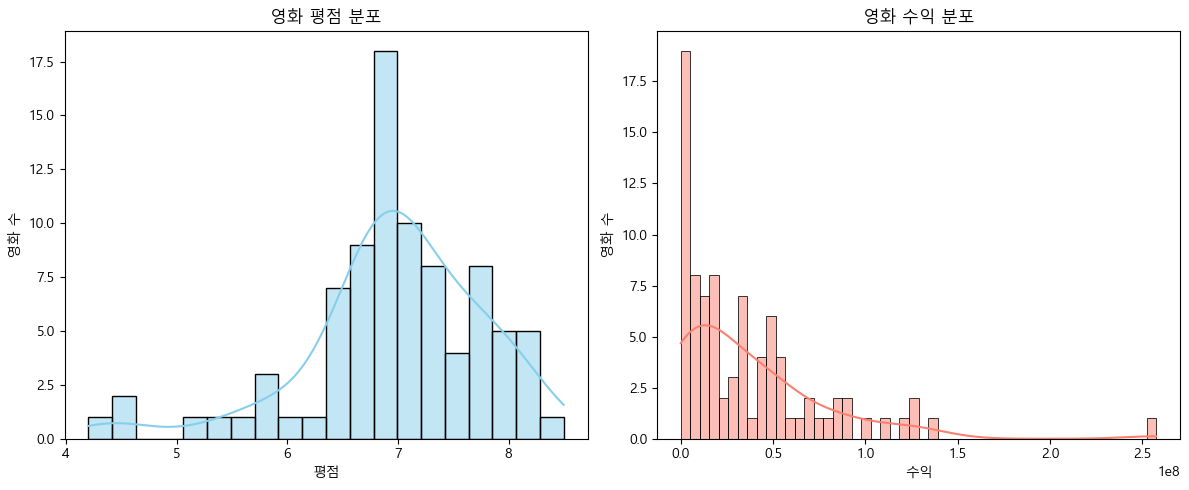

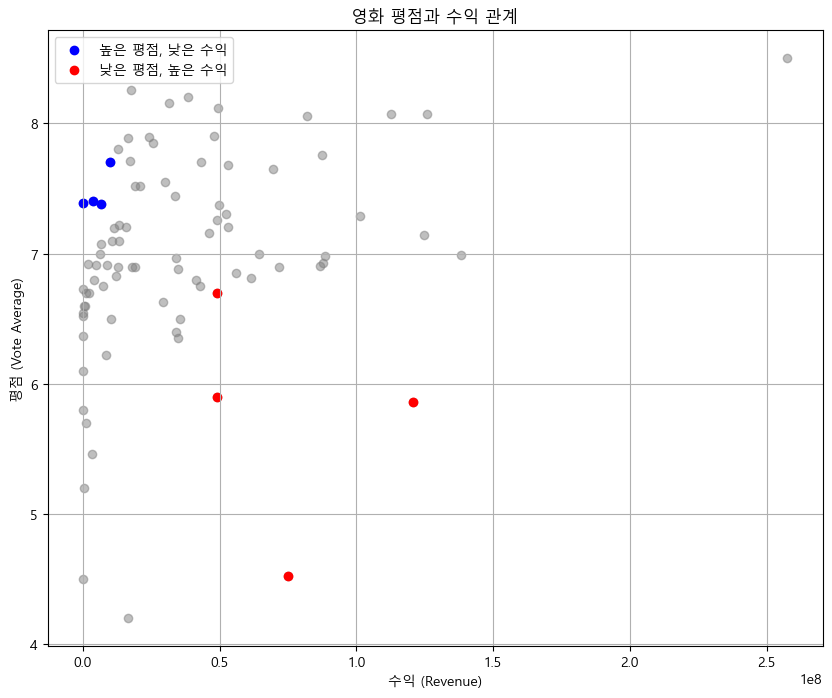

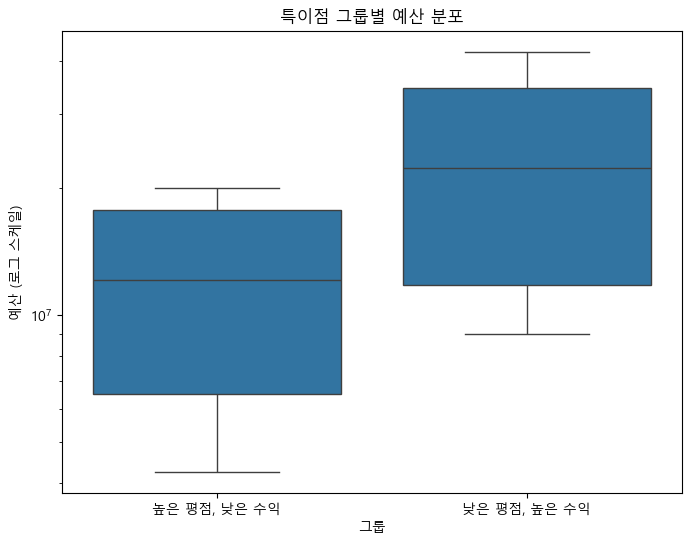

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re # Ï†ïÍ∑ú ÌëúÌòÑÏãù ÎùºÏù¥Î∏åÎü¨Î¶¨ Ï∂îÍ∞Ä

# Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows ÏÇ¨Ïö©ÏûêÏö©)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ (Ïù∏ÏΩîÎî© 'utf-8' ÎòêÎäî 'euc-kr'Î°ú ÏãúÎèÑ)
file_path = 'tmdb_kr_theatrical_clean.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='euc-kr')

# 2. ÌïÑÏöîÌïú Ïó¥Îßå Ï∂îÏ∂ú
df = df[['title', 'vote_average', 'revenue', 'budget', 'genres', 'original_language', 'popularity']]

# 3. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú: revenue ÎòêÎäî vote_averageÍ∞Ä 0Ïù∏ ÌñâÏùÄ Ï†úÏô∏
df = df[(df['revenue'] > 0) & (df['vote_average'] > 0)].copy()

# 4. ÌèâÏ†êÍ≥º ÏàòÏùµ Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
df[['normalized_vote', 'normalized_revenue']] = scaler.fit_transform(df[['vote_average', 'revenue']])

# 5. ÌäπÏù¥Ï†ê Í∑∏Î£π Ï†ïÏùò Î∞è Ï∂îÏ∂ú
high_vote_low_revenue_group = df[
    (df['normalized_vote'] >= df['normalized_vote'].quantile(0.7)) &
    (df['normalized_revenue'] <= df['normalized_revenue'].quantile(0.3))
]

low_vote_high_revenue_group = df[
    (df['normalized_vote'] <= df['normalized_vote'].quantile(0.3)) &
    (df['normalized_revenue'] >= df['normalized_revenue'].quantile(0.7))
]

# 6. Í≤∞Í≥º Ï∂úÎ†•
print("--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ Ïã§Ìå®) ---")
display(high_vote_low_revenue_group[['title', 'vote_average', 'revenue', 'genres', 'budget']].sort_values(by='vote_average', ascending=False).head(10))

print("\n--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏÑ±Í≥µ) ---")
display(low_vote_high_revenue_group[['title', 'vote_average', 'revenue', 'genres', 'budget']].sort_values(by='revenue', ascending=False).head(10))

# 7. Í∑∏Î£πÎ≥Ñ ÌäπÏÑ± Î∂ÑÏÑù (Ïû•Î•¥, ÏòàÏÇ∞, Ïñ∏Ïñ¥)
def get_genres(df):
    all_genres = []
    # Ï†ïÍ∑ú ÌëúÌòÑÏãùÏùÑ ÏÇ¨Ïö©Ìï¥ 'name': 'Ïû•Î•¥Ïù¥Î¶Ñ' ÎòêÎäî "name": "Ïû•Î•¥Ïù¥Î¶Ñ" Ìå®ÌÑ¥ÏùÑ Ï∞æÏäµÎãàÎã§.
    # Ï†ïÍ∑úÏãù Ìå®ÌÑ¥: 'name' Î¨∏ÏûêÏó¥, ÏΩúÎ°†, Í≥µÎ∞±, Îî∞Ïò¥Ìëú(' ÎòêÎäî "), Í∑∏Î£π(.*?)(ÏõêÌïòÎäî Îç∞Ïù¥ÌÑ∞), Îî∞Ïò¥Ìëú
    genre_pattern = re.compile(r"'name':\s*['\"](.*?)['\"]")
    
    for genres_str in df['genres'].astype(str).dropna():
        # genres_strÏù¥ '[]'Ïù∏ Í≤ΩÏö∞Îäî Îπà Î¶¨Ïä§Ìä∏Ïù¥ÎØÄÎ°ú Î¨¥Ïãú
        if genres_str.strip() in ['[]', 'nan']:
            continue
        
        # Ï†ïÍ∑ú ÌëúÌòÑÏãùÏúºÎ°ú Ïû•Î•¥ Ïù¥Î¶Ñ Ï∂îÏ∂ú
        genres_list = genre_pattern.findall(genres_str)
        all_genres.extend(genres_list)
        
    return Counter(all_genres)

print("\n--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---")
display(get_genres(high_vote_low_revenue_group).most_common(5))

print("\n--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---")
display(get_genres(low_vote_high_revenue_group).most_common(5))

print(f"\nÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: ${high_vote_low_revenue_group['budget'].mean():,.2f}")
print(f"ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: ${low_vote_high_revenue_group['budget'].mean():,.2f}")

print(f"\n--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ïñ∏Ïñ¥ Î∂ÑÌè¨ ---")
display(high_vote_low_revenue_group['original_language'].value_counts().head())

print(f"\n--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ïñ∏Ïñ¥ Î∂ÑÌè¨ ---")
display(low_vote_high_revenue_group['original_language'].value_counts().head())

# --- ÏãúÍ∞ÅÌôî Ï∂îÍ∞Ä ---
# 8. ÌèâÏ†ê Î∞è ÏàòÏùµ Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['vote_average'], bins=20, kde=True, color='skyblue')
plt.title('ÏòÅÌôî ÌèâÏ†ê Î∂ÑÌè¨')
plt.xlabel('ÌèâÏ†ê')
plt.ylabel('ÏòÅÌôî Ïàò')
plt.subplot(1, 2, 2)
sns.histplot(df['revenue'], bins=50, kde=True, color='salmon')
plt.title('ÏòÅÌôî ÏàòÏùµ Î∂ÑÌè¨')
plt.xlabel('ÏàòÏùµ')
plt.ylabel('ÏòÅÌôî Ïàò')
plt.tight_layout()
plt.show()

# 9. ÌèâÏ†ê vs. ÏàòÏùµ ÏÇ∞Ï†êÎèÑ
plt.figure(figsize=(10, 8))
plt.scatter(df['revenue'], df['vote_average'], alpha=0.5, color='gray')
plt.scatter(high_vote_low_revenue_group['revenue'], high_vote_low_revenue_group['vote_average'], color='blue', label='ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ')
plt.scatter(low_vote_high_revenue_group['revenue'], low_vote_high_revenue_group['vote_average'], color='red', label='ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ')
plt.title('ÏòÅÌôî ÌèâÏ†êÍ≥º ÏàòÏùµ Í¥ÄÍ≥Ñ')
plt.xlabel('ÏàòÏùµ (Revenue)')
plt.ylabel('ÌèâÏ†ê (Vote Average)')
plt.legend()
plt.grid(True)
plt.show()

# 10. Îëê Í∑∏Î£πÏùò ÏòàÏÇ∞ Î∂ÑÌè¨ ÎπÑÍµê (ÏÉÅÏûê Í∑∏Î¶º)
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='budget', data=pd.concat([
    high_vote_low_revenue_group.assign(group='ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ'),
    low_vote_high_revenue_group.assign(group='ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ')
]))
plt.yscale('log')
plt.title('ÌäπÏù¥Ï†ê Í∑∏Î£πÎ≥Ñ ÏòàÏÇ∞ Î∂ÑÌè¨')
plt.ylabel('ÏòàÏÇ∞ (Î°úÍ∑∏ Ïä§ÏºÄÏùº)')
plt.xlabel('Í∑∏Î£π')
plt.show()

ÏòÅÌôî ÌèâÏ†ê Î∞è ÏàòÏùµ Î∂ÑÌè¨ (ÌûàÏä§ÌÜ†Í∑∏Îû®)
ÏòÅÌôî ÌèâÏ†ê Î∂ÑÌè¨ (ÏôºÏ™Ω): Ïù¥ Í∑∏ÎûòÌîÑÎäî ÎåÄÎ∂ÄÎ∂ÑÏùò ÏòÅÌôîÍ∞Ä 6Ï†êÏóêÏÑú 8Ï†ê ÏÇ¨Ïù¥Ïùò ÎπÑÍµêÏ†Å ÎÜíÏùÄ ÌèâÏ†êÏóê ÏßëÏ§ëÎêòÏñ¥ ÏûàÏùåÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§. ÌèâÏ†êÏùÄ 7Ï†ê Î∂ÄÍ∑ºÏóê Í∞ÄÏû• ÎßéÏùÄ ÏòÅÌôîÍ∞Ä Î™∞Î†§ ÏûàÏñ¥, Ï¢Ö Î™®ÏñëÏùò Ï†ïÍ∑úÎ∂ÑÌè¨ÏôÄ Ïú†ÏÇ¨Ìïú Í≤ΩÌñ•ÏùÑ Î≥¥ÏûÖÎãàÎã§. Ïù¥Îäî ÎåÄÎã§Ïàò ÏòÅÌôîÍ∞Ä Î≥¥ÌÜµ Ïù¥ÏÉÅÏùò ÌèâÏ†êÏùÑ Í∏∞Î°ùÌïòÏßÄÎßå, Í∑πÎã®Ï†ÅÏúºÎ°ú ÎÇÆÍ±∞ÎÇò ÎÜíÏùÄ ÌèâÏ†êÏùò ÏòÅÌôîÎäî ÎìúÎ¨ºÎã§Îäî Í≤ÉÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.

ÏòÅÌôî ÏàòÏùµ Î∂ÑÌè¨ (Ïò§Î•∏Ï™Ω): Ïù¥ Í∑∏ÎûòÌîÑÎäî ÏàòÏùµÏù¥ 0Ïóê Í∞ÄÍπåÏö¥ ÎÇÆÏùÄ Í∞íÏóê ÏßëÏ§ëÎêòÏñ¥ ÏûàÍ≥†, ÏàòÏùµÏù¥ ÎÜíÏùÑÏàòÎ°ù ÏòÅÌôî ÏàòÍ∞Ä Í∏âÍ≤©Ìûà Ï§ÑÏñ¥ÎìúÎäî Ïò§Î•∏Ï™ΩÏúºÎ°ú ÏπòÏö∞Ïπú(right-skewed) Î∂ÑÌè¨Î•º Î≥¥ÏûÖÎãàÎã§. Ïù¥Îäî ÏòÅÌôî ÏãúÏû•ÏóêÏÑú ÏÜåÏàòÏùò Î∏îÎ°ùÎ≤ÑÏä§ÌÑ∞ ÏòÅÌôîÍ∞Ä Ï†ÑÏ≤¥ ÏàòÏùµÏùò ÎåÄÎ∂ÄÎ∂ÑÏùÑ Ï∞®ÏßÄÌïòÍ≥†, ÎåÄÎã§Ïàò ÏòÅÌôîÎäî ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏùÄ ÏàòÏùµÏùÑ Í∏∞Î°ùÌïúÎã§Îäî ÏÇ¨Ïã§ÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§.

ÏòÅÌôî ÌèâÏ†êÍ≥º ÏàòÏùµ Í¥ÄÍ≥Ñ (ÏÇ∞Ï†êÎèÑ)
Ïù¥ ÏÇ∞Ï†êÎèÑÎäî ÏòÅÌôîÏùò **ÌèâÏ†ê(YÏ∂ï)**Í≥º ÏàòÏùµ(XÏ∂ï) Í∞ÑÏùò Í¥ÄÍ≥ÑÎ•º Î≥¥Ïó¨Ï§çÎãàÎã§.

ÌöåÏÉâ Ï†ê: Ï†ÑÏ≤¥ ÏòÅÌôî Îç∞Ïù¥ÌÑ∞Î•º ÎÇòÌÉÄÎÇ¥Î©∞, ÎåÄÎ∂ÄÎ∂ÑÏùò ÏòÅÌôîÍ∞Ä ÎÇÆÏùÄ ÏàòÏùµÍ≥º Îã§ÏñëÌïú ÌèâÏ†ê Î≤îÏúÑÏóê ÎÑìÍ≤å Î∂ÑÌè¨ÌïòÍ≥† ÏûàÏùåÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§.

ÌååÎûÄÏÉâ Ï†ê: 'ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ' Í∑∏Î£πÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. Ïù¥ ÏòÅÌôîÎì§ÏùÄ ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå ÏàòÏùµÏùÄ Îß§Ïö∞ ÎÇÆÏùÄ Ï¢åÏ∏° ÏÉÅÎã®Ïóê ÏúÑÏπòÌïòÎ©∞, ÏûëÌíàÏÑ±ÏùÄ Îõ∞Ïñ¥ÎÇòÏßÄÎßå Ìù•ÌñâÏóêÎäî Ïã§Ìå®Ìïú ÏòÅÌôîÎì§ÏûÖÎãàÎã§.

Îπ®Í∞ÑÏÉâ Ï†ê: 'ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ' Í∑∏Î£πÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. Ïù¥ ÏòÅÌôîÎì§ÏùÄ ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå ÏàòÏùµÏùÄ ÎÜíÏùÄ Ïö∞Ï∏° ÌïòÎã®Ïóê ÏúÑÏπòÌïòÎ©∞, ÌèâÍ∞ÄÎäî Ï¢ãÏßÄ ÏïäÏïòÏßÄÎßå ÏÉÅÏóÖÏ†ÅÏúºÎ°ú ÏÑ±Í≥µÌïú ÏòÅÌôîÎì§ÏûÖÎãàÎã§.

ÌäπÏù¥Ï†ê Í∑∏Î£πÎ≥Ñ ÏòàÏÇ∞ Î∂ÑÌè¨ (ÏÉÅÏûê Í∑∏Î¶º)
Ïù¥ ÏÉÅÏûê Í∑∏Î¶ºÏùÄ Î°úÍ∑∏ Ïä§ÏºÄÏùºÎ°ú Î≥ÄÌôòÎêú ÏòàÏÇ∞ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨, Îëê ÌäπÏù¥Ï†ê Í∑∏Î£πÏùò ÏòàÏÇ∞ Î∂ÑÌè¨Î•º ÎπÑÍµêÌï©ÎãàÎã§.

ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÏôºÏ™Ω): Ïù¥ Í∑∏Î£πÏùò ÏòàÏÇ∞ Ï§ëÏïôÍ∞í(ÏÉÅÏûê ÏïàÏùò Í∞ÄÎ°úÏÑ†)ÏùÄ ÎÇÆÏùÄ Î≤îÏúÑÏóê ÏúÑÏπòÌï©ÎãàÎã§. Ïù¥Îäî ÏòÅÌôî ÏûêÏ≤¥Ïùò ÏôÑÏÑ±ÎèÑ(ÌèâÏ†ê)ÏôÄ Î¨¥Í¥ÄÌïòÍ≤å, ÏÉÅÎåÄÏ†ÅÏúºÎ°ú Ï†ÅÏùÄ Ï†úÏûëÎπÑÍ∞Ä Ìù•Ìñâ Î∂ÄÏßÑÏùò Ìïú ÏõêÏù∏Ïù¥ Îê† Ïàò ÏûàÏùåÏùÑ ÏãúÏÇ¨Ìï©ÎãàÎã§.

ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (Ïò§Î•∏Ï™Ω): Ïù¥ Í∑∏Î£πÏùò ÏòàÏÇ∞ Ï§ëÏïôÍ∞íÏùÄ ÏôºÏ™Ω Í∑∏Î£πÎ≥¥Îã§ Ìõ®Ïî¨ ÎÜíÏùÄ Î≤îÏúÑÏóê ÏúÑÏπòÌï©ÎãàÎã§. Ïù¥Îäî ÏûëÌíàÏÑ±Ïóê ÎåÄÌïú ÎÇÆÏùÄ ÌèâÍ∞ÄÏóêÎèÑ Î∂àÍµ¨ÌïòÍ≥†, ÎßâÎåÄÌïú ÏòàÏÇ∞Ïù¥ ÎßàÏºÄÌåÖ, ÏãúÍ∞Å Ìö®Í≥º Îì± Ìù•Ìñâ ÏöîÏÜåÏóê ÏÇ¨Ïö©ÎêòÏñ¥ ÏÉÅÏóÖÏ†Å ÏÑ±Í≥µÏùÑ Ïù¥ÎÅåÏóàÏùÑ Í∞ÄÎä•ÏÑ±Ïù¥ ÎÜíÏùåÏùÑ Î≥¥Ïó¨Ï§çÎãàÎã§.

--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ Ïã§Ìå®) ---


title  vote_average   revenue  \
56        Î†àÎìúÏäàÏ¶à         7.700  10054356   
13  ÏäàÌçºÎß®Ïù¥ÏóàÎçò ÏÇ¨ÎÇòÏù¥         7.400   3848034   
59          Í≥µÏûë         7.389      3175   
57          Î≤ÑÎãù         7.382   6591038   

                                        genres    budget  
56  ['Ïï†ÎãàÎ©îÏù¥ÏÖò', 'ÌåêÌÉÄÏßÄ', 'Í∞ÄÏ°±', 'ÏΩîÎØ∏Îîî', 'Î°úÎß®Ïä§', 'Î™®Ìóò']  20000000  
13                       ['ÏΩîÎØ∏Îîî', 'ÎìúÎùºÎßà', 'Î°úÎß®Ïä§']   4250000  
59                        ['ÎìúÎùºÎßà', 'Ïó≠ÏÇ¨', 'Ïä§Î¶¥Îü¨']  17000000  
57                      ['ÎØ∏Ïä§ÌÑ∞Î¶¨', 'ÎìúÎùºÎßà', 'Ïä§Î¶¥Îü¨']   7280000


--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏÑ±Í≥µ) ---


title  vote_average    revenue  \
36  ÎÑõÏû°: ÎïÖÏΩ© ÎèÑÎëëÎì§         5.857  120885527   
4          Îîî Ïõå         4.525   75108998   
48      Ïù∏Ï≤úÏÉÅÎ•ôÏûëÏ†Ñ         5.900   49196532   
34         Î≤†Î•ºÎ¶∞         6.700   48965210   

                                     genres    budget  
36             ['Ïï†ÎãàÎ©îÏù¥ÏÖò', 'ÏΩîÎØ∏Îîî', 'Í∞ÄÏ°±', 'Î™®Ìóò']  42000000  
4   ['ÌåêÌÉÄÏßÄ', 'ÎìúÎùºÎßà', 'Í≥µÌè¨', 'Ïï°ÏÖò', 'Ïä§Î¶¥Îü¨', 'SF']  32000000  
48                ['Ïó≠ÏÇ¨', 'ÎìúÎùºÎßà', 'Ï†ÑÏüÅ', 'Ïï°ÏÖò']  12700000  
34                      ['Ïï°ÏÖò', 'Ïä§Î¶¥Îü¨', 'Î≤îÏ£Ñ']   9000000


--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---


[('ÎìúÎùºÎßà', 3), ('ÏΩîÎØ∏Îîî', 2), ('Î°úÎß®Ïä§', 2), ('Ïä§Î¶¥Îü¨', 2), ('Ïï†ÎãàÎ©îÏù¥ÏÖò', 1)]


--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---


[('Ïï°ÏÖò', 3), ('ÎìúÎùºÎßà', 2), ('Ïä§Î¶¥Îü¨', 2), ('ÌåêÌÉÄÏßÄ', 1), ('Í≥µÌè¨', 1)]


ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: $12,132,500.00
ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: $23,925,000.00


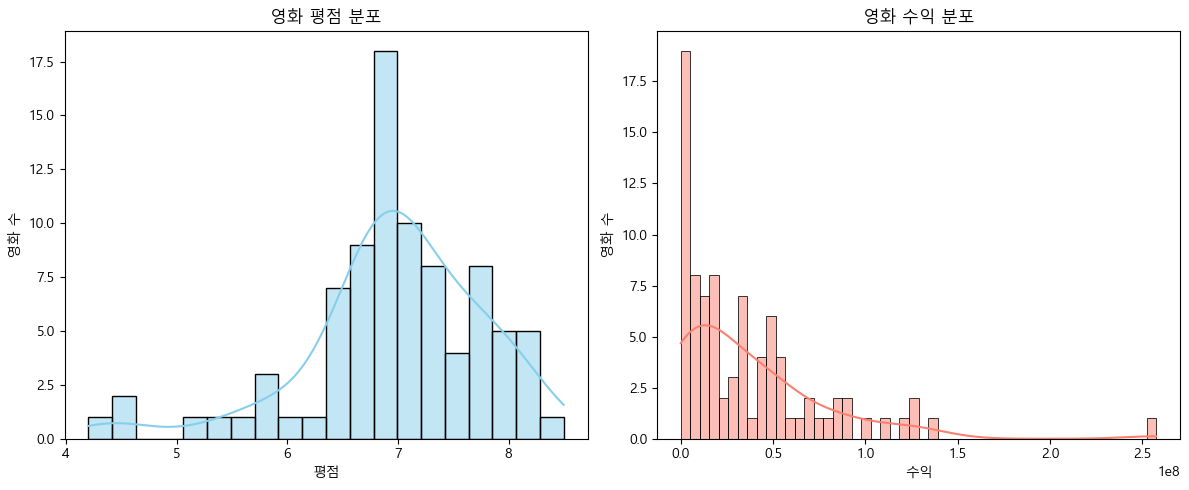

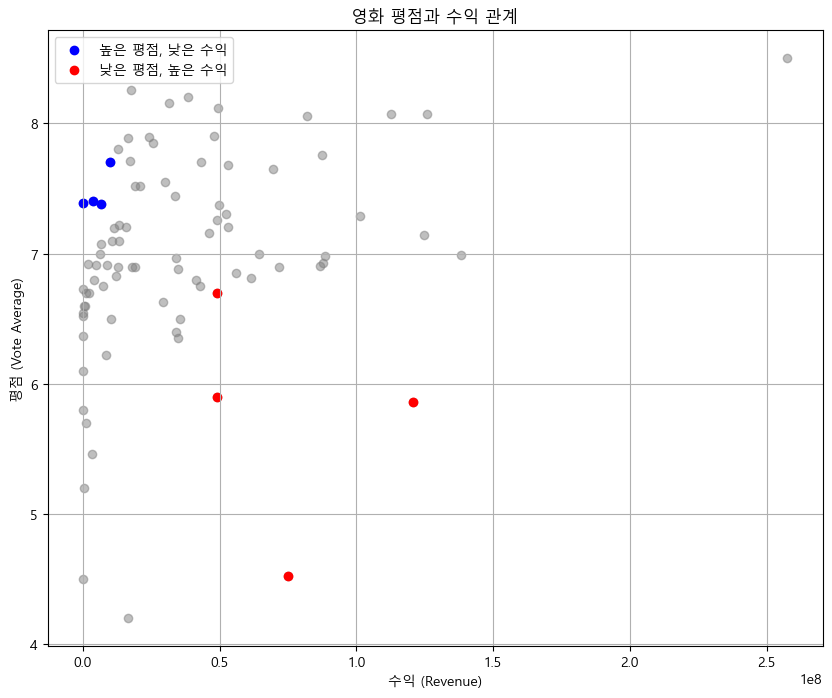

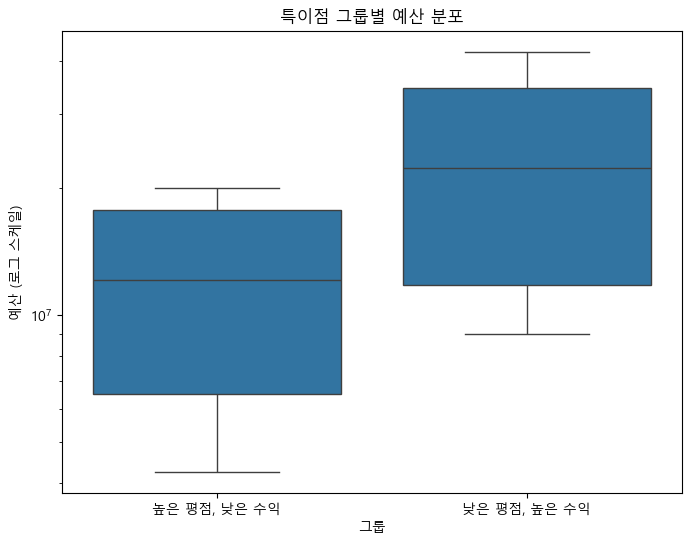

In [21]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Ìè∞Ìä∏ ÏÑ§Ï†ï (Windows ÏÇ¨Ïö©ÏûêÏö©)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
file_path = 'tmdb_kr_theatrical_clean.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='euc-kr')

# 2. ÌïÑÏöîÌïú Ïó¥Îßå Ï∂îÏ∂ú
df = df[['title', 'vote_average', 'revenue', 'budget', 'genres', 'original_language', 'popularity']]

# 3. Îç∞Ïù¥ÌÑ∞ Ï†ïÏ†ú
df = df[(df['revenue'] > 0) & (df['vote_average'] > 0)].copy()

# 4. ÌèâÏ†êÍ≥º ÏàòÏùµ Ï†ïÍ∑úÌôî
scaler = MinMaxScaler()
df[['normalized_vote', 'normalized_revenue']] = scaler.fit_transform(df[['vote_average', 'revenue']])

# 5. ÌäπÏù¥Ï†ê Í∑∏Î£π Ï†ïÏùò
high_vote_low_revenue_group = df[
    (df['normalized_vote'] >= df['normalized_vote'].quantile(0.7)) &
    (df['normalized_revenue'] <= df['normalized_revenue'].quantile(0.3))
]

low_vote_high_revenue_group = df[
    (df['normalized_vote'] <= df['normalized_vote'].quantile(0.3)) &
    (df['normalized_revenue'] >= df['normalized_revenue'].quantile(0.7))
]

# ‚úÖ 6. Ïû•Î•¥ Ï∂îÏ∂ú Ìï®Ïàò (Ï†ïÍ∑ú ÌëúÌòÑÏãù Î∞©Ïãù)
def get_genres(df):
    all_genres = []
    genre_pattern = re.compile(r"'(.*?)'")  # ÏûëÏùÄÎî∞Ïò¥Ìëú ÏïàÏùò ÌÖçÏä§Ìä∏ Ï∂îÏ∂ú

    for genres_str in df['genres'].astype(str).dropna():
        if genres_str.strip() in ['[]', 'nan']:
            continue

        genres_list = genre_pattern.findall(genres_str)
        all_genres.extend(genres_list)

    return Counter(all_genres)

# 7. Í≤∞Í≥º Ï∂úÎ†•
print("--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÜíÏßÄÎßå Ìù•Ìñâ Ïã§Ìå®) ---")
display(high_vote_low_revenue_group[['title', 'vote_average', 'revenue', 'genres', 'budget']].sort_values(by='vote_average', ascending=False).head(10))

print("\n--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£π (ÌèâÏ†êÏùÄ ÎÇÆÏßÄÎßå Ìù•Ìñâ ÏÑ±Í≥µ) ---")
display(low_vote_high_revenue_group[['title', 'vote_average', 'revenue', 'genres', 'budget']].sort_values(by='revenue', ascending=False).head(10))

print("\n--- ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---")
display(get_genres(high_vote_low_revenue_group).most_common(5))

print("\n--- ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò Ï£ºÏöî Ïû•Î•¥ ---")
display(get_genres(low_vote_high_revenue_group).most_common(5))

print(f"\nÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: ${high_vote_low_revenue_group['budget'].mean():,.2f}")
print(f"ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ Í∑∏Î£πÏùò ÌèâÍ∑† ÏòàÏÇ∞: ${low_vote_high_revenue_group['budget'].mean():,.2f}")


# 8. ÌèâÏ†ê Î∞è ÏàòÏùµ Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['vote_average'], bins=20, kde=True, color='skyblue')
plt.title('ÏòÅÌôî ÌèâÏ†ê Î∂ÑÌè¨')
plt.xlabel('ÌèâÏ†ê')
plt.ylabel('ÏòÅÌôî Ïàò')

plt.subplot(1, 2, 2)
sns.histplot(df['revenue'], bins=50, kde=True, color='salmon')
plt.title('ÏòÅÌôî ÏàòÏùµ Î∂ÑÌè¨')
plt.xlabel('ÏàòÏùµ')
plt.ylabel('ÏòÅÌôî Ïàò')

plt.tight_layout()
plt.show()

# 9. ÌèâÏ†ê vs. ÏàòÏùµ ÏÇ∞Ï†êÎèÑ
plt.figure(figsize=(10, 8))
plt.scatter(df['revenue'], df['vote_average'], alpha=0.5, color='gray')
plt.scatter(high_vote_low_revenue_group['revenue'], high_vote_low_revenue_group['vote_average'], color='blue', label='ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ')
plt.scatter(low_vote_high_revenue_group['revenue'], low_vote_high_revenue_group['vote_average'], color='red', label='ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ')
plt.title('ÏòÅÌôî ÌèâÏ†êÍ≥º ÏàòÏùµ Í¥ÄÍ≥Ñ')
plt.xlabel('ÏàòÏùµ (Revenue)')
plt.ylabel('ÌèâÏ†ê (Vote Average)')
plt.legend()
plt.grid(True)
plt.show()

# 10. ÏòàÏÇ∞ Î∂ÑÌè¨ ÎπÑÍµê (ÏÉÅÏûê Í∑∏Î¶º)
plt.figure(figsize=(8, 6))
sns.boxplot(x='group', y='budget', data=pd.concat([
    high_vote_low_revenue_group.assign(group='ÎÜíÏùÄ ÌèâÏ†ê, ÎÇÆÏùÄ ÏàòÏùµ'),
    low_vote_high_revenue_group.assign(group='ÎÇÆÏùÄ ÌèâÏ†ê, ÎÜíÏùÄ ÏàòÏùµ')
]))
plt.yscale('log')
plt.title('ÌäπÏù¥Ï†ê Í∑∏Î£πÎ≥Ñ ÏòàÏÇ∞ Î∂ÑÌè¨')
plt.ylabel('ÏòàÏÇ∞ (Î°úÍ∑∏ Ïä§ÏºÄÏùº)')
plt.xlabel('Í∑∏Î£π')
plt.show()